<a href="https://colab.research.google.com/github/sourcecode369/unconventional-neural-networks/blob/master/neural-style-transfer/Neural_Style_Transfer_Keras_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import range, input

### Lazy Programmer

In [2]:
# try:
#   %tensorflow_version 2.x
# except:
#   print("Unable to load TensorFlow 2.x.")
# import tensorflow as tf 
# print(f"TensorFlow version: {tf.__version__}")

from keras.layers import ( Input, Lambda, 
                                     Dense, Flatten, 
                                     AveragePooling2D, 
                                     MaxPooling2D, MaxPool2D, 
                                     Conv2D )
from keras.models import Model, Sequential
from keras.applications.vgg16 import ( VGG16, 
                                                 preprocess_input, 
                                                 decode_predictions )
from keras.preprocessing import image
import keras.backend as K

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

Using TensorFlow backend.


In [0]:
def VGG16_AvgPool(shape):
  vgg = VGG16(weights='imagenet', input_shape=shape, include_top=False)
  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D or layer.__class__ == MaxPool2D:
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)
  return new_model

In [0]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  if num_convs < 1 or num_convs > 13:
    raise ValueError("Num of convs must be in the range [1,13].")
    return None

  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  
  n = 0
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
  
    new_model.add(layer)
  
    if n >= num_convs:
      break
  
  return new_model

In [0]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img[..., ::-1]
  return img

In [0]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

In [7]:
import urllib
urllib.request.urlretrieve('https://i.pinimg.com/originals/a7/67/8b/a7678be0f68e85976ad3733fd6354196.jpg', 'content.jpg')
urllib.request.urlretrieve('https://harishnarayanan.org/images/writing/artistic-style-transfer/edtaonisl.jpg','style.jpg')

('style.jpg', <http.client.HTTPMessage at 0x7fecc1e063c8>)

In [8]:
if __name__ == '__main__':
  path = 'content.jpg'
  img = image.load_img(path)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  batch_shape = x.shape
  shape = x.shape[1:]
  content_model = VGG16_AvgPool_CutOff(shape, 11)
  target = K.variable(content_model.predict(x))
  loss = K.mean(K.square(target - content_model.output))
  grads = K.gradients(loss, content_model.input)
  get_loss_and_grads = K.function(
      inputs = [content_model.input],
      outputs = [loss] + grads
  )





58892288/58889256 [==============================] - 2s 0us/step









In [0]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=0.0
iter=1, loss=0.07577025145292282
iter=2, loss=0.0356273278594017
iter=3, loss=0.0384240560233593
iter=4, loss=0.03920716792345047
iter=5, loss=0.03972989320755005
iter=6, loss=0.03972989320755005
iter=7, loss=0.03972989320755005
iter=8, loss=0.03972989320755005
iter=9, loss=0.03972989320755005
duration:  0:01:07.029868


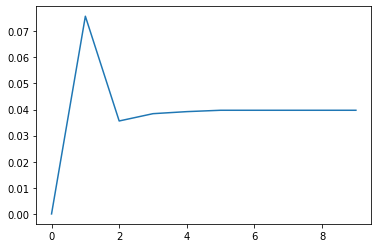

In [10]:
from datetime import datetime
t0 = datetime.now()
losses = []
for i in range(10):
  x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0 = x,
      maxfun=20
  )
  x = np.clip(x, -127, 127)
  print("iter=%s, loss=%s"%(i,l))
  losses.append(l)

print("duration: ", datetime.now() - t0)
plt.plot(losses)
plt.show()

newimg = x.reshape(*batch_shape)
final_image = unpreprocess(newimg)

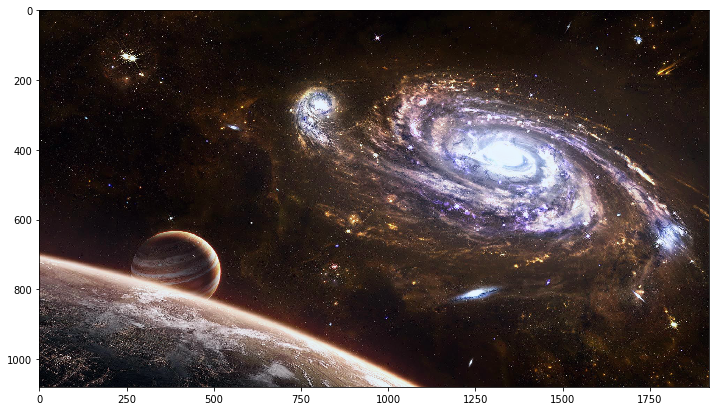

In [11]:
plt.figure(figsize=(12,10))
plt.imshow(scale_img(final_image[0]))
plt.show()